In [1]:
# Import Packages
import os
import earthaccess
import netCDF4 as nc
from osgeo import gdal
import pandas as pd
import numpy as np
import xarray as xr
import hvplot.pandas
import hvplot.xarray
import holoviews as hv
import sys
import matplotlib.pyplot as plt
import ast
sys.path.append('modules/')
import emit_tools
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import interpolate
from matplotlib.colors import LinearSegmentedColormap


In [2]:
earthaccess.login(persist=True)

In [3]:
df = pd.read_csv('data/lake_chla_results.csv')

df['granule_urls'] = df['granule_urls'].apply(ast.literal_eval)
urls = []

for granules in df['granule_urls']:

    urls.append(granules[0])  # Append the 1st URL (RFL)
    urls.append(granules[2])  # Append the 2nd URL (MASK)

fs = earthaccess.get_requests_https_session()
# Retrieve granule asset ID from URL (to maintain existing naming convention)
for url in urls:
    granule_asset_id = url.split('/')[-1]
    fp = f'../granules/{granule_asset_id}'
    # Download the Granule Asset if it doesn't exist
    if not os.path.isfile(fp):
        with fs.get(url,stream=True) as src:
            with open(fp,'wb') as dst:
                for chunk in src.iter_content(chunk_size=64*1024*1024):
                    dst.write(chunk)


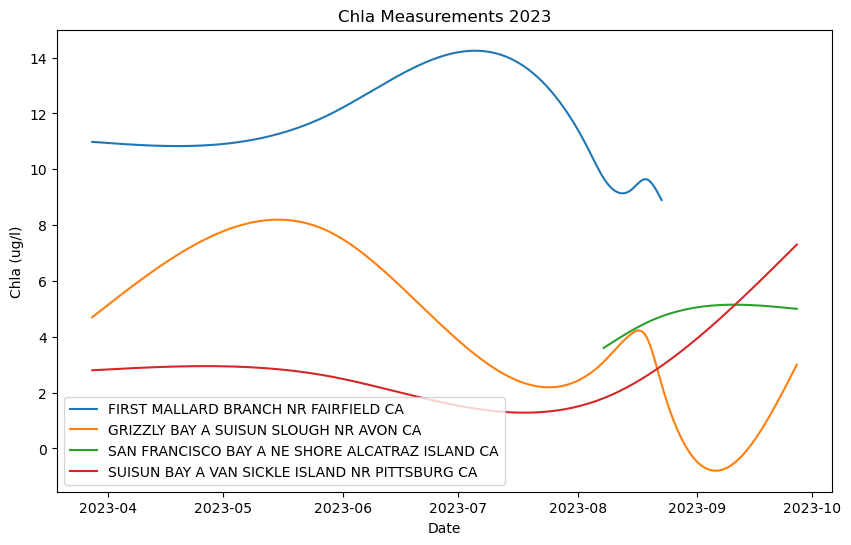

In [4]:

df['result_time'] = pd.to_datetime(df['result_time'], utc=True)

# Group by station name and result time, and take the average if multiple results exist for the same timestamp
df_grouped = df.groupby(['station_nm', 'result_time'], as_index=False).agg({'result': 'mean'})

# Create a line plot for each station
plt.figure(figsize=(10,6))
for station in df_grouped['station_nm'].unique():
    station_data = df_grouped[df_grouped['station_nm'] == station]
    
    # Sort values to avoid errors in interpolation
    station_data = station_data.sort_values(by='result_time')
    
    # Create more data points using interpolation
    x_new = np.linspace(station_data['result_time'].min().value, station_data['result_time'].max().value, 500)
    
    # Interpolating the 'result' values using a cubic spline interpolation (handle time values in days)
    time_in_days = (station_data['result_time'] - station_data['result_time'].min()).dt.total_seconds() / (60*60*24)  # Convert to days
    
    spline = interpolate.CubicSpline(time_in_days, station_data['result'], bc_type='natural')  # Prevents sharp edges
    
    # Generate new x values in days
    x_new_days = np.linspace(time_in_days.min(), time_in_days.max(), 500)
    y_new = spline(x_new_days)
    
    # Plot the interpolated data
    plt.plot(station_data['result_time'].min() + pd.to_timedelta(x_new_days, unit='d'), y_new, label=station)

plt.xlabel('Date')
plt.ylabel('Chla (ug/l)')
plt.title('Chla Measurements 2023')
plt.legend()
plt.show()


In [36]:
fp = '../granules/EMIT_L2A_RFL_001_20230926T223356_2326915_002.nc'
fp_mask = '../granules/EMIT_L2A_MASK_001_20230926T223356_2326915_002.nc'

In [37]:

mask_parameters_ds = xr.open_dataset(fp_mask,engine = 'h5netcdf', group='sensor_band_parameters')
mask_key = mask_parameters_ds['mask_bands'].to_dataframe()
mask_key


,mask_bands
bands,
0,Cloud flag
1,Cirrus flag
2,Water flag
3,Spacecraft Flag
4,Dilated Cloud Flag
5,AOD550
6,H2O (g cm-2)
7,Aggregate Flag


Flags used: ['Cloud flag' 'Cirrus flag' 'Spacecraft Flag' 'Dilated Cloud Flag']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.15835302..12.196049].


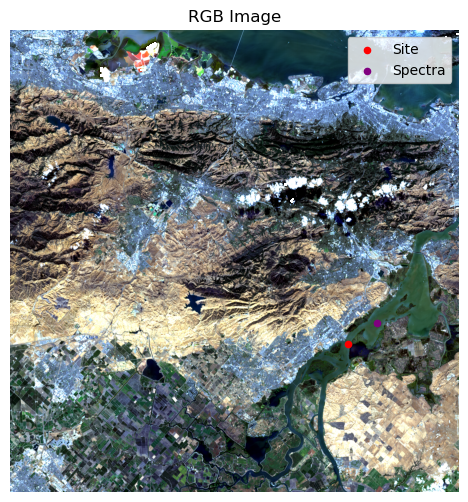

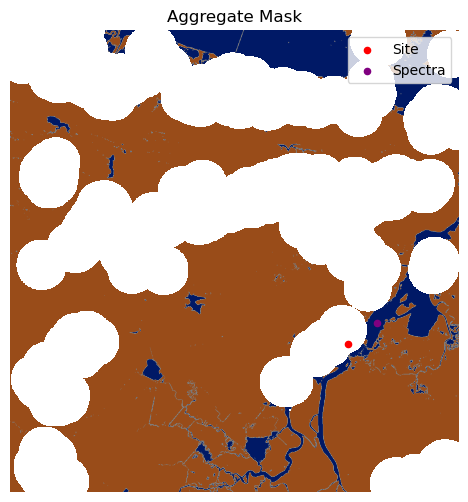

In [38]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.spatial import cKDTree

ds = emit_tools.emit_xarray(fp, ortho = False)
mask_ds = emit_tools.emit_xarray(fp_mask, ortho=False)

noise_flags = [0, 1, 3, 4]
noise_mask = emit_tools.quality_mask(fp_mask, noise_flags)
water_mask = (mask_ds['mask'].values[...,2])
agg_mask = np.where(noise_mask == 1, np.nan, water_mask)

colors = [(0.6, 0.3, 0.1),  # dark 
          (0.5, 0.5, 0.5),  # gray 
          (0.0, 0.1, 0.4)]  # brown
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

lats = ds['lat'].values
lons = ds['lon'].values

site_lat = 38.04953056
site_lon = -121.88755
site_dist = np.sqrt((lats - site_lat)**2 + (lons - site_lon)**2)
site_idx = np.unravel_index(np.argmin(site_dist), site_dist.shape)

spec_lat = 38.06382
spec_lon = -121.95996
spec_dist = np.sqrt((lats - spec_lat)**2 + (lons - spec_lon)**2)
spec_idx = np.unravel_index(np.argmin(spec_dist), spec_dist.shape)
	


rgb_inds = np.array([np.nanargmin(abs(ds['wavelengths'].values - x)) for x in [650, 560, 470]])
rgb = ds['reflectance'].values[:,:,rgb_inds] # subset RGB
rgb[rgb < 0] = np.nan
rgb -= np.nanpercentile(rgb,2,axis=(0,1))[np.newaxis,np.newaxis,:] # scale from 2-95 %
rgb /= np.nanpercentile(rgb,95,axis=(0,1))[np.newaxis,np.newaxis,:]

# Plot the RGB image
plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.scatter(site_idx[1], site_idx[0], color='red', label='Site', s=20)
plt.scatter(spec_idx[1], spec_idx[0], color='purple', label='Spectra', s=20)
plt.axis('off')
plt.title('RGB Image')
plt.legend()

# Plot the Custom Water Mask
plt.figure(figsize=(10, 6))
plt.imshow(agg_mask, cmap=custom_cmap)
plt.scatter(site_idx[1], site_idx[0], color='red', label='Site', s=20)
plt.scatter(spec_idx[1], spec_idx[0], color='purple', label='Spectra', s=20)
plt.axis('off')
plt.title('Aggregate Mask')
plt.legend()

plt.show()

In [9]:
print(ds)

<xarray.Dataset> Size: 2GB
Dimensions:           (downtrack: 1280, crosstrack: 1242, wavelengths: 285,
                       ortho_y: 2005, ortho_x: 2301)
Coordinates:
  * downtrack         (downtrack) int64 10kB 0 1 2 3 4 ... 1276 1277 1278 1279
  * crosstrack        (crosstrack) int64 10kB 0 1 2 3 4 ... 1238 1239 1240 1241
    lon               (downtrack, crosstrack) float64 13MB ...
    lat               (downtrack, crosstrack) float64 13MB ...
    elev              (downtrack, crosstrack) float64 13MB ...
    glt_x             (ortho_y, ortho_x) float64 37MB ...
    glt_y             (ortho_y, ortho_x) float64 37MB ...
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    fwhm              (wavelengths) float32 1kB ...
    good_wavelengths  (wavelengths) float32 1kB ...
Dimensions without coordinates: ortho_y, ortho_x
Data variables:
    reflectance       (downtrack, crosstrack, wavelengths) float32 2GB 0.4177...
Attributes: (12/39)
    ncei_template_versi